In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = (all_digits.astype("float32")-127.5) / 127.5 #đưa tấm hình về [0,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

In [ ]:
#mô hình của mạng Discrimimator
discriminator=keras.Sequential()

discriminator.add(keras.Input(shape=(28,28,1)))

discriminator.add(keras.layers.BatchNormalization())
discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.Dense(units=1024))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.3))

discriminator.add(keras.layers.Dense(units=512))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.3))

discriminator.add(keras.layers.Dense(units=256))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.3))

discriminator.add(keras.layers.Dense(1))

discriminator.add(keras.layers.Activation(activation="sigmoid",name="sigmoid"))  #do đây là mô hình dự đoán cho 2 nhãn nên dùng sigmoid

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                      

In [ ]:
#mô hình của mạng Generator
latten_dim=100
generator=keras.Sequential()

generator.add(keras.Input(shape=(latten_dim,)))

generator.add(keras.layers.Dense(units=256))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

generator.add(keras.layers.Dense(units=512))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

generator.add(keras.layers.Dense(units=1024))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

generator.add(keras.layers.Dense(units=28*28))
generator.add(keras.layers.Activation(activation="tanh",name="tanh"))  #Đưa về một tấm ảnh nên dùng tanh để về [-1,1]

generator.add(keras.layers.Reshape((28,28,1)))
generator.add(keras.layers.BatchNormalization())

generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 784)              

In [ ]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator(random_latent_vectors)

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Ở đây đánh nhãn ảnh thật là 1, ảnh giả là 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 1 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}



In [ ]:
#overwrite callback để lúc huấn luyện xem ảnh in ra
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images *= 255 #Đưa ảnh về [0,255]
        generated_images.numpy() 
        print("epoch ",epoch)
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            display(img) #in ảnh

In [ ]:
epochs = 30 #số epochs
latent_dim =100 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)],verbose=0
    )

epoch  0


epoch  1


epoch  2


epoch  3


epoch  4


epoch  5


epoch  6


epoch  7


epoch  8


epoch  9


epoch  10


epoch  11


epoch  12


epoch  13


epoch  14


epoch  15


epoch  16


epoch  17


epoch  18


epoch  19


epoch  20


epoch  21


epoch  22


epoch  23


epoch  24


epoch  25


epoch  26


epoch  27


epoch  28


epoch  29


#Bài tập
1. Dụa vào mô hình GAN ở trên hãy tạo ra một mô hình DCGAN và train trên tập Mnist

2. Sau khi train xong hãy viết một hàm sao cho khi đưa vào 4 lattent random vectors thì mô hình sẽ tạo ra 4 samples

Generator:

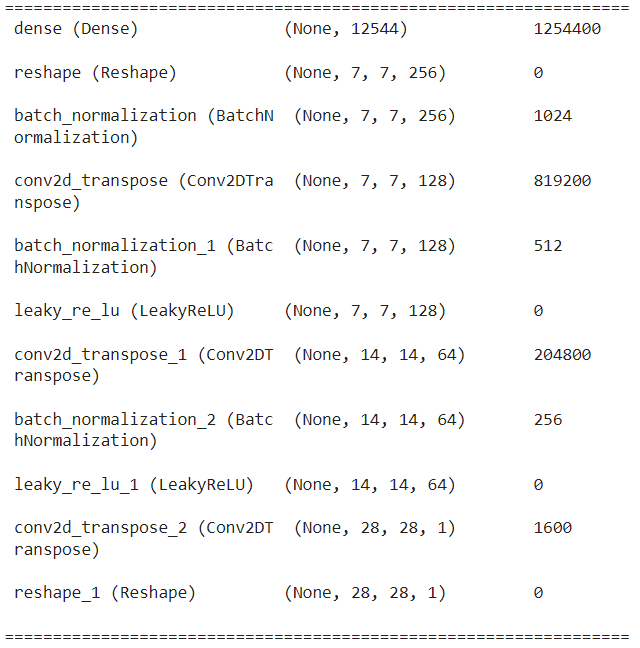

Discriminator: 

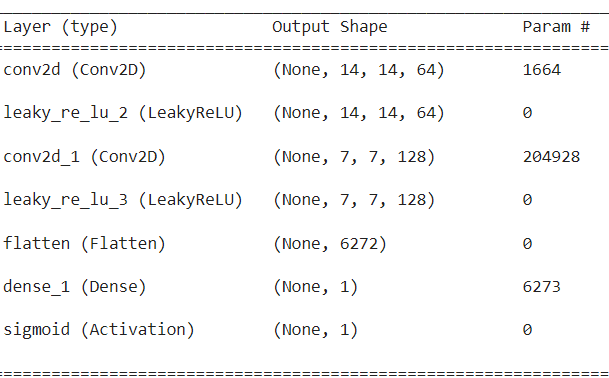

In [ ]:
generator = keras.Sequential()

generator.add(keras.Input(shape=(100,)))

generator.add(keras.layers.Dense(units=7*7*256,
                          use_bias=False))
generator.add(keras.layers.Reshape((7,7,256)))

generator.add(keras.layers.BatchNormalization())

generator.add(keras.layers.Conv2DTranspose(filters=128,
                                           kernel_size=[5,5],
                                           strides=(1,1),
                                           padding="same",
                                           use_bias=False))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.LeakyReLU(0.2))

generator.add(keras.layers.Conv2DTranspose(filters=64,
                                           kernel_size=[5,5],
                                           strides=(2,2),
                                           padding="same",
                                           use_bias=False))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.LeakyReLU(0.2))

generator.add(keras.layers.Conv2DTranspose(filters=1,
                                           kernel_size=[5,5],
                                           strides=(2,2),
                                           padding="same",
                                           use_bias=False,
                                           activation="tanh"))
generator.add(keras.layers.Reshape((28,28,1)))


generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                        

In [ ]:
discriminator=keras.Sequential()
discriminator.add(keras.layers.Input((28,28,1)))
discriminator.add(keras.layers.Convolution2D(filters=64,
                                             kernel_size=[5,5],
                                             strides=[2,2],
                                             padding="same"))
discriminator.add(keras.layers.LeakyReLU(0.2))

discriminator.add(keras.layers.Convolution2D(filters=128,
                                             kernel_size=[5,5],
                                             strides=[2,2],
                                             padding="same"))
discriminator.add(keras.layers.LeakyReLU(0.2))

discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.Dense(units=1))
discriminator.add(keras.layers.Activation(activation="sigmoid",name="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
 sigmoid (Activation)        (None, 1)                

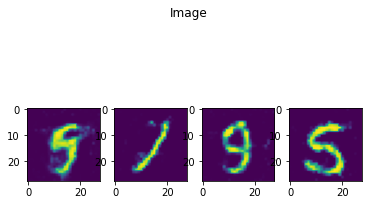

In [ ]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(4, 100))
generated_images = gan.generator(random_latent_vectors)
generated_images *= 255
generated_images.numpy()
fig, axs = plt.subplots(1,4)
fig.suptitle('Image')
for i in range(4):
  img = keras.preprocessing.image.array_to_img(generated_images[i])
  axs[i].imshow(img)